In [1]:
#importing the libraries
import numpy as np

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from reproject import reproject_interp

from astroquery.skyview import SkyView
from astroquery.vizier import Vizier

from spectral_cube import SpectralCube
import pandas as pd
import os

## This is only a test to know how to work with the other cubes

In [3]:
file = 'j170209-6138_cube_4k.fits' # the name of fits file that is in the directory of work.
information= fits.open(file)# this part allow us to read the fits file.
# the fits file has a header but in this case the main part is the data from the fits file.
h=information[0].header
data_main = information[0].data

In [4]:
# checking the data
print(data_main.shape, ' this is the previous shape of the data cube')
# This is a 4 dimensional data cube: RA, DEC coordinates, frequency, polarisation
# However HI is unpolarised emissio, so the 4th axis in this case is meaningless
data_main2 = data_main[0,:,60:66,60:66]# with this part we are omitting the firts dimensional data cube
print(data_main2.shape, 'this is the shape of the new data cube')

(1, 140, 128, 128)  this is the previous shape of the data cube
(140, 6, 6) this is the shape of the new data cube


In [5]:
import matplotlib.patches as patches

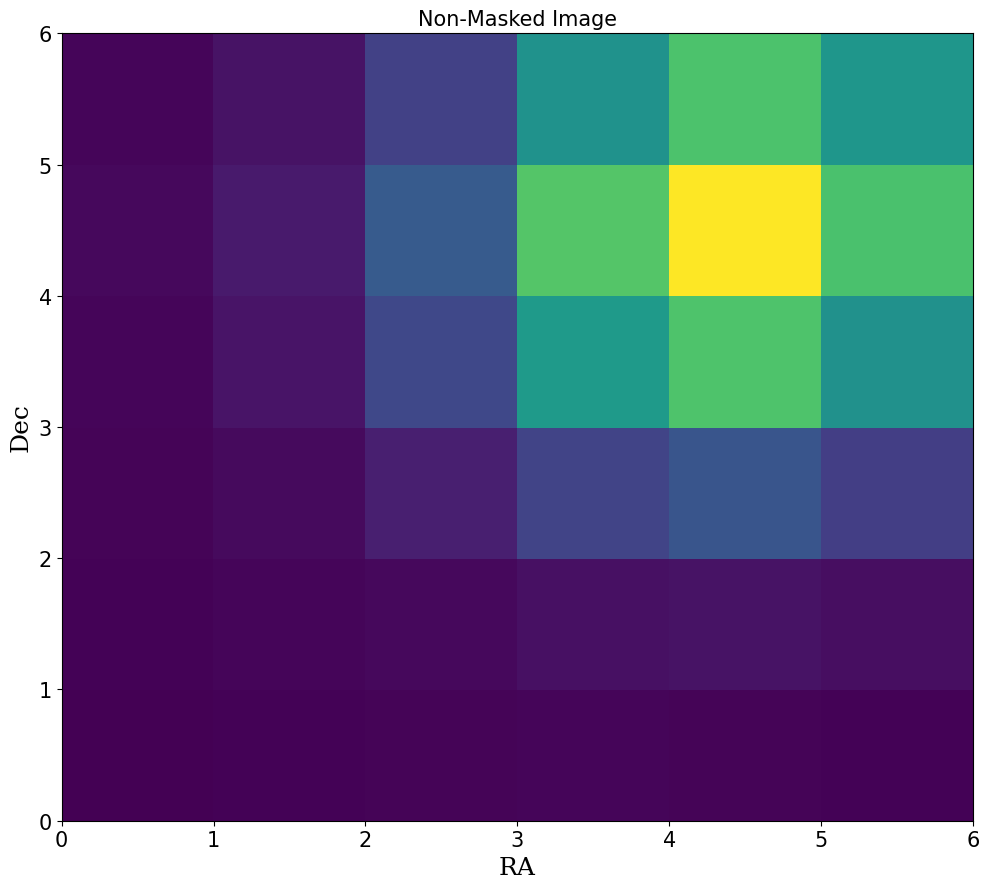

In [6]:
d_2_av = np.mean(data_main2, axis=0)
fig,ax=plt.subplots(figsize=(10,9))
ff=plt.pcolor(d_2_av,cmap='viridis')
plt.title('Non-Masked Image', fontsize=15)
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
#ax.scatter(pixels_atca[0], pixels_atca[1], c='magenta', label="astrophysical")
#patch = patches.Circle((64, 64), radius=5, transform=ax.transData)
#ff.set_clip_path(patch)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

In [9]:
#defining the function to calculate the root mean square of the data
def root_mean(x):
    rms = np.sqrt(np.mean(x**2))
    return rms

rms = root_mean(data_main2)
print(rms)

0.04999144


In [10]:
data_main3 = np.where( data_main2 <rms, 0, data_main2) #-np.where( data_main2 < 3*rms, 0, data_main2)# in this part, i am giving the value 0 for data less than 5 rms
#print(data_main3.shape)
data_main4= data_main2-data_main3#np.where(data_main2 < rms, 0, data_main2)# in this part, i am giving the value 0 for data less than 5 rms
print(data_main4.shape)
data_main5= np.where(data_main4 != 0, data_main4, np.nan)

(140, 6, 6)


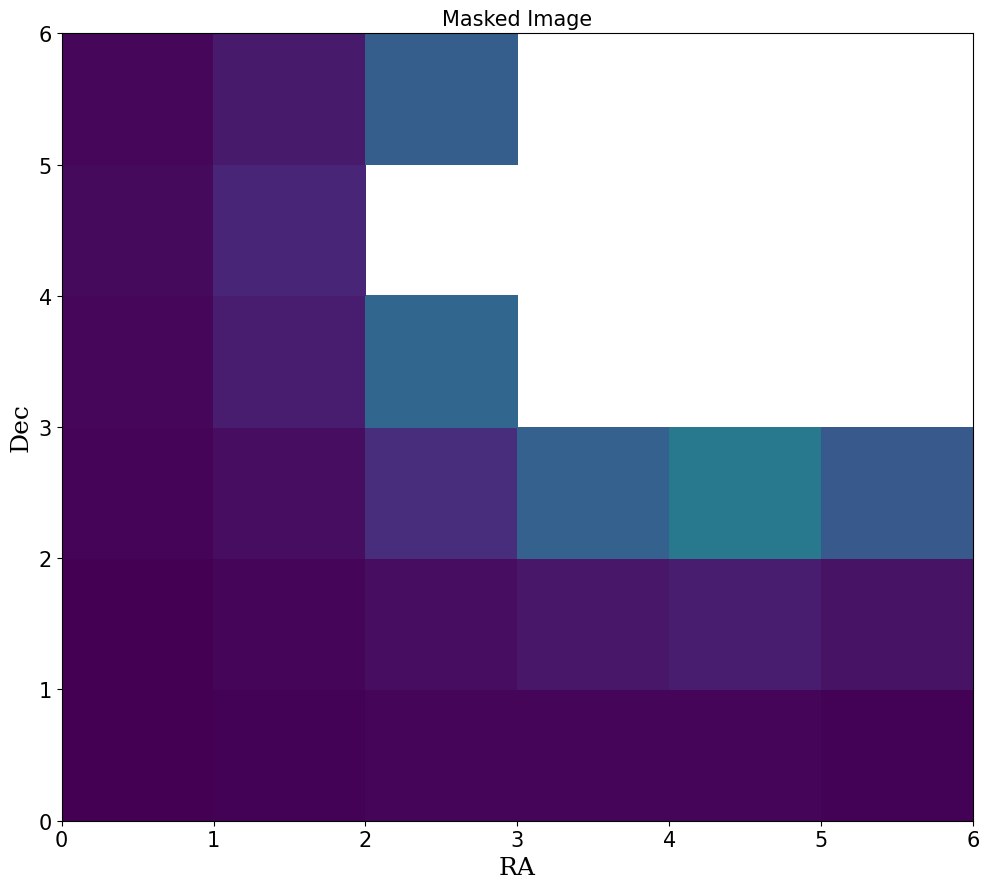

In [11]:
#making a plot of the masked data
moment_0 = np.sum(data_main5, axis=0)* abs(h['CDELT3'])/1000  # this is the 0 orderd moment of the data also called moment 0
fig,ax=plt.subplots(figsize=(10,9))
plt.pcolor(moment_0,cmap='viridis',vmin = 0.0, vmax = 50.0)
plt.title('Masked Image', fontsize=15)
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

# Function to get the data from all cubes

In [12]:
def get_spectrum(file):
    cube_file = fits.open(file)  # Open the FITS file for reading
    data = cube_file[0].data
    header = cube_file[0].header
    #getting the central coordinates
    central_x = header['NAXIS1'] // 2
    central_y = header['NAXIS2'] // 2
    # Define the region of interest
    region_size = 3  # Number of pixels on each side of the central pixel
    x_start = central_x - region_size
    x_end = central_x + region_size + 1
    y_start = central_y - region_size
    y_end = central_y + region_size + 1
    #extracting the region
    data_main = data[0,:,x_start:x_end,y_start:y_end]
    #let's extract the source
    rms=root_mean(data_main)#root mean square of the information
    #condition to generate the envelope
    data_main2 = np.where( data_main <rms/2, 0, data_main)
    #envelope
    data_main3= data_main-data_main2
    data_main4=np.where(data_main3 != 0, data_main3, np.nan)
    #getting the spectrum Toff region
    averaged_spectrum = np.nanmean(data_main4, axis=(1, 2))
    source=data[0,:,central_x,central_y]
    #standard deviation of the Toff
    s_off=np.std(averaged_spectrum)
    
    return s_off,averaged_spectrum,source,data_main4

### example

In [13]:
a=get_spectrum('j170209-6138_cube_4k.fits')

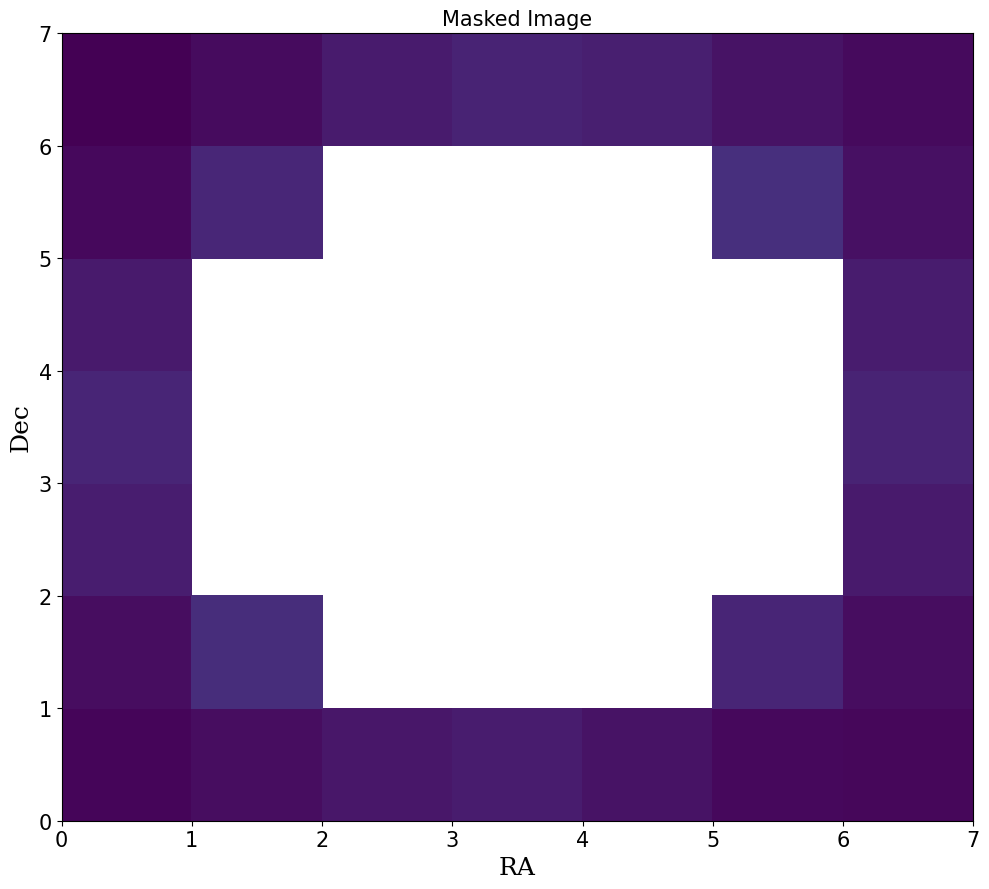

In [14]:
#making a plot of the masked data
moment_0 = np.sum(a[3], axis=0)* abs(h['CDELT3'])/1000  # this is the 0 orderd moment of the data also called moment 0
fig,ax=plt.subplots(figsize=(10,9))
plt.pcolor(moment_0,cmap='viridis',vmin = 0.0, vmax = 50.0)
plt.title('Masked Image', fontsize=15)
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

## Functions that allow to work (this is the general situation)

In [15]:
#defining the function to calculate the root mean square of the data
def root_mean(x):
    rms = np.sqrt(np.mean(x**2))
    return rms

In [16]:
def get_spectrum(file):
    cube_file = fits.open(file)  # Open the FITS file for reading
    data = cube_file[0].data
    header = cube_file[0].header
    #getting the central coordinates
    central_x = header['NAXIS1'] // 2
    central_y = header['NAXIS2'] // 2
    # Define the region of interest
    region_size = 3  # Number of pixels on each side of the central pixel
    x_start = central_x - region_size
    x_end = central_x + region_size + 1
    y_start = central_y - region_size
    y_end = central_y + region_size + 1
    #extracting the region
    data_main = data[0,:,x_start:x_end,y_start:y_end]
    #let's extract the source
    rms=root_mean(data_main)#root mean square of the information
    data_main2 = np.where( data_main <rms/2, 0, data_main)
    data_main3= data_main-data_main2
    data_main4=np.where(data_main3 != 0, data_main3, np.nan)
    #getting the spectrum
    averaged_spectrum = np.nanmean(data_main4, axis=(1, 2))
    source=data[0,:,central_x,central_y]
    s_off=np.nanstd(averaged_spectrum)
   # t_on=np.mean(source)
    return s_off,averaged_spectrum,source,data_main4

## Path

In [17]:
#creating a list in order to get the full path of the required file
# 4k resolution
def full_path(file,folder):
    information=[]
    for i in range(len(file)):
        f="/home/vicente/cold_hi_project/data_cubes_4k/"+folder+'/'+file[i]
        information.append(f)
    return information

In [18]:
# 2v resolution
def full_path1(file,folder):
    information=[]
    for i in range(len(file)):
        f="/home/vicente/cold_hi_project/data_cubes_v2/"+folder+'/'+file[i]
        information.append(f)
    return information

### Hydra V4

In [19]:
key1="Hydra"
key2="Norma"

In [18]:
contenido = os.listdir("/home/vicente/cold_hi_project/data_cubes_4k/"+key1)

In [19]:
s=full_path(contenido, key1)

In [20]:
off=[]
on=[]
st=[]
for i in s:
    st.append(get_spectrum(i)[0])
    off.append(get_spectrum(i)[1])
    on.append(get_spectrum(i)[2])
   

### Saving the information for Hydra V4

In [22]:
hydra_v4 = pd.DataFrame({'Name': contenido, 'T_off':off,
                   'T_on':on, "S_off":st})

hydra_v4.to_pickle('Analysis_Hydra_v4.pkl')

In [31]:
hydrav4= pd.read_pickle("Analysis_Hydra_v4.pkl")


### Saving the information for Norma V4

In [24]:
contenido = os.listdir("/home/vicente/cold_hi_project/data_cubes_4k/"+key2)

In [25]:
s=full_path(contenido, key2)

In [26]:
off=[]
on=[]
st=[]
for i in s:
    st.append(get_spectrum(i)[0])
    off.append(get_spectrum(i)[1])
    on.append(get_spectrum(i)[2])

/tmp/ipykernel_22081/1370673906.py:22: RuntimeWarning: Mean of empty slice
  averaged_spectrum = np.nanmean(data_main4, axis=(1, 2))


In [27]:
norma_v4 = pd.DataFrame({'Name': contenido, 'T_off':off,
                   'T_on':on,
                        'S_off':st})

norma_v4.to_pickle("Analysis_Norma_v4.pkl")

In [30]:
normav4= pd.read_pickle("Analysis_Norma_v4.pkl")

### Saving the information for Hydra V2

In [29]:
contenido1 = os.listdir("/home/vicente/cold_hi_project/data_cubes_v2/"+key1)

In [30]:
s1=full_path1(contenido1, key1)

In [31]:
off=[]
on=[]
st=[]
for i in s1:
    st.append(get_spectrum(i)[0])
    off.append(get_spectrum(i)[1])
    on.append(get_spectrum(i)[2])

In [32]:
hydra_v2 = pd.DataFrame({'Name': contenido1, 'T_off':off,
                   'T_on':on,
                        'S_off': st})

hydra_v2.to_pickle("Analysis_Hydra_v2.pkl")

In [29]:
hydrav2= pd.read_pickle("Analysis_Hydra_v2.pkl")

In [34]:
#hydrav2

### Saving the information for Norma V2

In [35]:
contenido1 = os.listdir("/home/vicente/cold_hi_project/data_cubes_v2/"+key2)
s2=full_path1(contenido1, key2)
off=[]
on=[]
st=[]
for i in s2:
    st.append(get_spectrum(i)[0])
    off.append(get_spectrum(i)[1])
    on.append(get_spectrum(i)[2])

/tmp/ipykernel_22081/1370673906.py:22: RuntimeWarning: Mean of empty slice
  averaged_spectrum = np.nanmean(data_main4, axis=(1, 2))


In [28]:
norma_v2 = pd.DataFrame({'Name': contenido1, 'T_off':off,
                   #'T_on':on,'S_off':st})

norma_v2.to_pickle("Analysis_Norma_v2.pkl")


In [32]:
normav2= pd.read_pickle("Analysis_Norma_v2.pkl")

## Calling the generated data

In [33]:
hydrav4;


In [34]:
normav4;

In [35]:
hydrav2;


In [36]:
normav2;

### These are the files that were generated in the second notebook (histograms)

In [37]:
normav2_inf=pd.read_pickle("Information_Norma_v2.pkl");

In [38]:
normav4_inf=pd.read_pickle("Information_Norma_v4.pkl");

In [39]:
hydrav2_inf=pd.read_pickle("Information_Hydra_v2.pkl");

In [40]:
hydrav4_inf=pd.read_pickle("Information_Hydra_v4.pkl");

## Analysis Norma V4

### Filtering the data in order to have the same number of files for every case.

In [41]:
#normav4_inf

In [42]:
cont = os.listdir("/home/vicente/cold_hi_project/data_cubes_4k/"+key2)

In [43]:
#print(cont)

In [44]:
# Clasifying the data 
coll=[]
for i in cont:
    coll.append(i.split('.')[0])

In [45]:
normav4['Name']=coll

In [46]:
m=[]
for i in normav4_inf['Name']:
    m.append(i.split('_atca')[0])

In [47]:
normav4_inf['Name']=m

In [48]:
merged_norma_v4 = normav4_inf.merge(normav4, on='Name')

In [49]:
#merged_norma_v4 

In [50]:
merged_norma_v4.to_pickle("Norma_Full_v4.pkl")
merged_normav4 = pd.read_pickle("Norma_Full_v4.pkl")

In [51]:
#merged_normav4

## Analysis Hydra V4

In [52]:
#hydrav4

In [53]:
#hydrav4_inf

In [54]:
cont = os.listdir("/home/vicente/cold_hi_project/data_cubes_4k/"+key1)

In [55]:
# Clasifying the data depending on the velocity resolution
coll=[]
for i in cont:
    coll.append(i.split('.')[0])

In [56]:
hydrav4['Name']=coll

In [57]:
m=[]
for i in hydrav4_inf['Name']:
    m.append(i.split('_atca')[0])

In [58]:
hydrav4_inf['Name']=m

In [59]:
merged_hydra_v4 = hydrav4_inf.merge(hydrav4, on='Name')

In [60]:
merged_hydra_v4 .to_pickle("Hydra_Full_v4.pkl")
merged_hydrav4 = pd.read_pickle("Hydra_Full_v4.pkl")

In [61]:
#merged_hydrav4

## Analysis Hydra V2

In [71]:
cont = os.listdir("/home/vicente/cold_hi_project/data_cubes_v2/"+key1)
# Clasifying the data depending on the velocity resolution
coll=[]
for i in cont:
    coll.append(i.split('.')[0])

hydrav2['Name']=coll
m=[]
for i in hydrav2_inf['Name']:
    m.append(i.split('_atca')[0])

hydrav2_inf['Name']=m

merged_hydra_v2 = hydrav2_inf.merge(hydrav2, on='Name')


In [72]:
merged_hydra_v2 .to_pickle("Hydra_Full_v2.pkl")
merged_hydrav2= pd.read_pickle("Hydra_Full_v2.pkl")

In [64]:
#merged_hydrav2

## Analysis Norma V2

In [73]:
cont = os.listdir("/home/vicente/cold_hi_project/data_cubes_v2/"+key2)
# Clasifying the data depending on the velocity resolution
coll=[]
for i in cont:
    coll.append(i.split('.')[0])

normav2['Name']=coll
m=[]
for i in normav2_inf['Name']:
    m.append(i.split('_atca')[0])

normav2_inf['Name']=m

merged_norma_v2 = normav2_inf.merge(normav2, on='Name')

In [74]:
merged_norma_v2 .to_pickle("Norma_Full_v2.pkl")
merged_normav2= pd.read_pickle("Norma_Full_v2.pkl")

In [67]:
#merged_normav2

## Calculating the uncertainty envelop

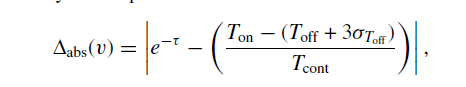

In [75]:
def envelope(file):
    env=np.abs(file['tau']-((file['T_on']-(file['T_off']+3*file['S_off']))/file['T_cont']))
    return env
    

In [76]:
def standar(file):
    ff=[]
    for i in range(len(file['U.env'])):
        ff.append(np.nanstd(file['U.env'][i]))
    return ff

### Adding two columns, one with the envelope and the standard deviation of it.

In [77]:
merged_normav2['U.env']=envelope(merged_normav2)
merged_normav2['S.env']=standar(merged_normav2)

In [78]:
merged_normav4['U.env']=envelope(merged_normav4)
merged_normav4['S.env']=standar(merged_normav4)

In [79]:
merged_hydrav2['U.env']=envelope(merged_hydrav2)
merged_hydrav2['S.env']=standar(merged_hydrav2)

In [80]:
merged_hydrav4['U.env']=envelope(merged_hydrav4)
merged_hydrav4['S.env']=standar(merged_hydrav4)

Each of the frames above contain all the information about the spectra, including the uncertainty envelop.
Now, let's classify the spectra  in differente categories.

# Norma V2

### This functions allow us to classify the spectra in different quality factors.

In [81]:
#this is the option to classify based in the criteria that we want (mode): S/N, sigma, S.range, etc
#Function to classify the spectra on quality factors
def classification_sn(file,mode):  
    file[mode+'L']=file[mode]
    a=np.max(file[mode])
    b=np.min(file[mode])
    r=(a-b)/6
    for i in range(len(file[mode])):
        if mode=='S/N':
            if b<=file[mode][i]<=b+r:
                file.at[i,mode+'L']='F'
            if b+r<file[mode][i]<=b+2*r:
                file.at[i,mode+'L']='E'
            if b+2*r<file[mode][i]<=b+3*r:
                file.at[i,mode+'L']='D'
            if b+3*r<file[mode][i]<=b+4*r:
                file.at[i,mode+'L']='C'
            if b+4*r<file[mode][i]<=b+5*r:
                file.at[i,mode+'L']='B'
            if b+5*r<file[mode][i]<=a:
                file.at[i,mode+'L']='A'
        else:
            if b<=file[mode][i]<=b+r:
                file.at[i,mode+'L']='A'
            if b+r<file[mode][i]<=b+2*r:
                file.at[i,mode+'L']='B'
            if b+2*r<file[mode][i]<=b+3*r:
                file.at[i,mode+'L']='C'
            if b+3*r<file[mode][i]<=b+4*r:
                file.at[i,mode+'L']='D'
            if b+4*r<file[mode][i]<=b+5*r:
                file.at[i,mode+'L']='E'
            if b+5*r<file[mode][i]<=a:
                file.at[i,mode+'L']='F'

### This function allow us the classification based on a test of the different criteria

In [82]:
def classify(file):
    file['L']=file['S/N']
    condition1=file['S/N'] >3
    condition2=file['S.Range'] <1.5
    condition3=3*file['S.env']<1
    condition4=3*file['S.Deviation']<1
    m=file.loc[(condition1) & (condition2) & (condition3) & (condition4)]
    m1=file.loc[(condition1 & condition2 & condition3) | (condition1 & condition2 & condition4) |
                (condition1 & condition3 & condition4) | (condition2 & condition3 & condition4)]
    
    m2=file.loc[(condition1 & condition2) | (condition1 & condition3) | (condition1 & condition4)|
               (condition2 & condition3) | (condition2 & condition4) | (condition3 & condition4)]
    m3=file.loc[(condition1) | (condition2) |(condition3)|(condition4)]
    m4=file.loc[~(condition1) & ~(condition2) & ~(condition3) & ~(condition4)]
    file.loc[file['Name'].isin(m3['Name']), 'L'] = 'D'
    file.loc[file['Name'].isin(m2['Name']), 'L'] = 'C'
    file.loc[file['Name'].isin(m1['Name']), 'L'] = 'B'
    file.loc[file['Name'].isin(m['Name']), 'L'] = 'A'
    file.loc[file['Name'].isin(m4['Name']), 'L'] = 'E'
    return file
    


In [83]:
#it works if you want to  get an histogram of the quality factors
def histograms(file, title, text): # allow to plot histograms. arguments: data, title of the plot, x_label of the plot; the 
    #last two must be strings
    plt.hist(file,color = "lightblue", ec="black")
    plt.xlabel(text)
    plt.ylabel("Counts")
    plt.title(title)
    plt.show()

# Norma V2

In [84]:
nv2=classify(merged_normav2)

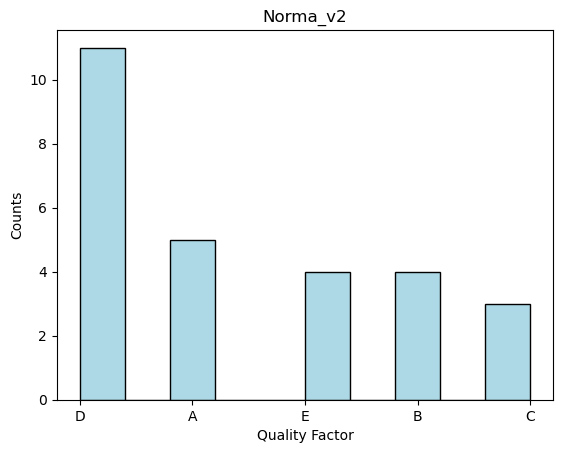

In [85]:
histograms(nv2['L'], 'Norma_v2','Quality Factor')

### if you want to plot bar plots of the quality factors

In [86]:
from collections import Counter


In [103]:
def plot_freq(file, text):
    letras=file['L']
    frec= Counter(letras)
    # Obtener los valores y las etiquetas
    valores = list(frec.values())
    etiquetas = list(frec.keys())
    # Crear el gráfico de barras
    plt.bar(etiquetas, valores, color='gray')
    for i in range(len(etiquetas)):
        plt.text(etiquetas[i], valores[i], str(valores[i]), ha='center', va='bottom')
    plt.title(text)
    #ordered=['A','B','C','D','E']
    #plt.xticks(etiquetas, ordered)
    plt.xlabel('Quality Factor')
    plt.ylabel('Frequency')
    plt.show()
    

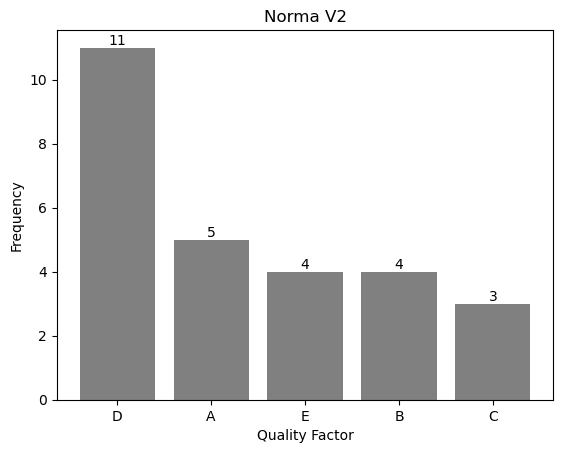

In [104]:
plot_freq(nv2, 'Norma V2')

# Norma V4

In [105]:
nv4=classify(merged_normav4)

In [106]:
nv4

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,L
0,j163254-5938_cube_4k,1.012467,0.158393,2.799868,0.330859,0.926362,1.257221,"[0.042530983062486746, 0.04254030528372538, 0....","[1.0204701813789288, 0.9594086062098386, 1.163...","[-189.100704507, -185.18464886647, -181.268593...","[0.007953435, 0.008256505, 0.008220643, 0.0081...","[0.034958925, 0.033542924, 0.040050708, 0.0371...",0.001229,"[0.4722152470969503, 0.45168421210090515, 0.50...",0.040531,B
1,j165824-6116_cube_4k,1.006085,0.110483,4.839416,0.140724,0.681022,0.821746,"[0.12096863320789887, 0.12099467939031347, 0.1...","[1.006670297668937, 1.0565367059457176, 1.0750...","[-189.611520226, -185.69545791712, -181.779395...","[0.031289257, 0.032483198, 0.034069665, 0.0286...","[0.12788723, 0.14276326, 0.13287051, 0.1472630...",0.002422,"[0.26819479719253403, 0.20514014235587763, 0.3...",0.043641,A
2,j162700-6043_cube_4k,1.003848,0.087808,2.432215,0.185919,0.452195,0.638114,"[0.0806538992183123, 0.08066739197251582, 0.08...","[1.0013665276292392, 1.1312469359501718, 1.034...","[-190.206675061, -186.29060498277, -182.374534...","[0.004785371, 0.0060734106, 0.0048848838, 0.00...","[0.11219585, 0.12379762, 0.11526055, 0.1104888...",0.000749,"[0.3025153429990255, 0.3002718118877823, 0.305...",0.041967,B
3,j171029-6041_cube_4k,1.000674,0.036711,8.236657,0.041651,0.343064,0.384715,"[0.9277290553043571, 0.9278218484952502, 0.927...","[1.0416508402692704, 1.006816946071067, 1.0073...","[-188.501902864, -184.58585504042, -180.669807...","[0.077052414, 0.07225245, 0.071543306, 0.07252...","[1.550213, 1.5191228, 1.5149522, 1.5277368, 1....",0.004370,"[0.5321381233001863, 0.5384792467778612, 0.534...",0.029271,A
4,j163925-6044_cube_4k,1.004459,0.094541,3.831340,0.182904,0.700767,0.883671,"[0.07870304738699639, 0.07871146495861207, 0.0...","[1.1337112470532156, 1.0466341852907708, 1.061...","[-190.746019941, -186.82994282199, -182.913865...","[0.0050291833, 0.0049379417, 0.0044683903, 0.0...","[0.121061586, 0.11425968, 0.11513901, 0.115513...",0.000717,"[0.31326915049271253, 0.31493497638880497, 0.3...",0.043335,A
5,j165636-6055_cube_4k,1.004717,0.097197,6.621226,0.106076,0.702350,0.808426,"[0.18148796871894995, 0.18157554162782427, 0.1...","[1.1060755785462704, 0.995382518921283, 1.0360...","[-189.584575248, -185.66851329087, -181.752451...","[0.045222234, 0.04874153, 0.04546508, 0.050561...","[0.23249462, 0.22352861, 0.2303504, 0.2288234,...",0.003446,"[0.13117173436617535, 0.08970983598739202, 0.0...",0.034269,A
6,j162150-6045_cube_4k,1.002145,0.065526,3.148669,0.131319,0.413481,0.544800,"[0.0988206887602322, 0.09883689185494711, 0.09...","[0.9785155842681539, 1.0282430790028245, 1.032...","[-190.01613511, -186.10006751914, -182.1839999...","[0.007972244, 0.0061665904, 0.007604703, 0.006...","[0.14167148, 0.14774081, 0.15250702, 0.1435518...",0.000715,"[0.3527114329105938, 0.3824423805167272, 0.411...",0.032353,A
7,j160011-5810_cube_4k,1.002046,0.063979,9.721913,0.047786,0.464568,0.512354,"[0.5259671454331329, 0.5261055391833243, 0.526...","[1.0427836886053712, 1.0261785132276977, 1.045...","[-188.145571452, -184.22952828008, -180.313485...","[0.045332786, 0.04601871, 0.04574263, 0.044546...","[0.74305063, 0.7367749, 0.7465482, 0.7375887, ...",0.002755,"[0.2680444399953028, 0.271072502075808, 0.2703...",0.023622,A
8,j161717-5848_cube_4k,1.000880,0.041950,18.695071,0.018774,0.350988,0.369763,"[3.6055999749827534, 3.6060397985287365, 3.606...","[1.0171337712019877, 1.0171353908785128, 1.018...","[-191.423701185, -187.50761521932003, -183.591...","[0.30605417, 0.3039748, 0.3084479, 0.30760354,...","[5.405578, 5.4076037, 5.4206285, 5.401467, 5.4...",0.004426,"[0.3935178740428591, 0.39448259236616234, 0.39...",0.019823,A
9,j170706-5802_cube_4k,1.001436,0.053614,8.894143,0.062331,0.554380,0.616711,"[0.3059047220672227, 0.3059501021885576, 0.305...","[0.9948053692781065, 1.0192273111509436, 0.993...","[-189.138335424, -185.22227929

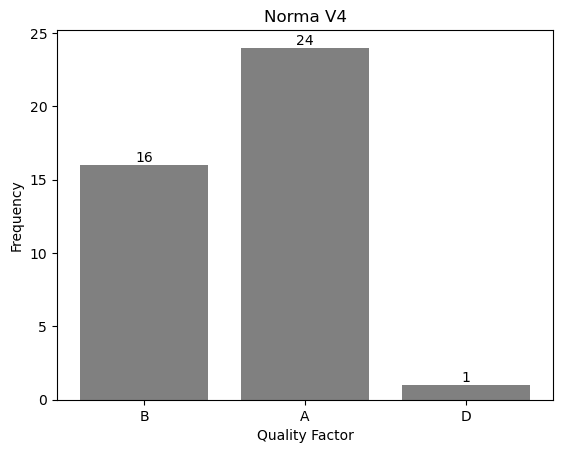

In [107]:
plot_freq(nv4, 'Norma V4')

# Hydra V2


In [108]:
hv2=classify(merged_hydrav2)

In [109]:
hv2

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,L
0,j101448-2944_cube_v2,1.015895,0.179003,1.378702,0.576773,0.795198,1.371971,"[0.05446548298906166, 0.054465059204750706, 0....","[0.6974654022186696, 1.0340818650039654, 0.981...","[-141.731690232, -141.525584069403, -141.31947...","[0.0029639732, 0.0027989785, 0.0037379921, 0.0...","[0.055690803, 0.08650606, 0.083565235, 0.09470...",0.001254,"[0.20153216151002262, 0.433732352243561, 0.414...",0.111037,B
1,j102229-2647_cube_v2,1.021929,0.210568,0.717456,0.833672,0.598123,1.431796,"[0.0741701685644957, 0.07416811398137559, 0.07...","[1.1328976544920886, 0.7511513642370595, 1.272...","[-160.46988205, -160.263745304649, -160.057608...","[0.007369771, -0.0007924658, 0.011879301, 0.00...","[0.2109097, 0.15082866, 0.18899031, 0.15696697...",0.003621,"[1.4648847630066764, 1.1466880508346997, 0.969...",0.218145,B
2,j101153-2610_cube_v2,1.002029,0.063729,0.834408,0.229095,0.191159,0.420254,"[0.3980898559836335, 0.39809002780130254, 0.39...","[1.0290130578379806, 1.0215957486957912, 1.024...","[-141.08011613099998, -140.87401041614598, -14...","[0.041361444, 0.03457511, 0.039043386, 0.04506...","[0.679061, 0.6471227, 0.68487185, 0.7045503, 0...",0.004083,"[0.542112284826997, 0.48634730807186766, 0.566...",0.046435,B
3,j100916-2840_cube_v2,1.031682,0.253700,1.225292,0.803610,0.984657,1.788267,"[0.0375449740467146, 0.03754385769569629, 0.03...","[1.127190178566744, 1.3945156734919542, 0.8086...","[-142.01851566500002, -141.812409305305, -141....","[0.00021525113, 0.0009423047, 0.00096942263, 0...","[0.06321158, 0.07908281, 0.051927526, 0.064842...",0.001312,"[0.44585727877661996, 0.5819514124836127, 0.44...",0.143513,C
4,j103631-2553_cube_v2,1.007091,0.119295,0.868353,0.437726,0.380100,0.817826,"[0.21421313962056365, 0.21420955015343823, 0.2...","[1.108693707681418, 1.0786562962972142, 0.9851...","[-112.718578942, -112.512475012792, -112.30637...","[0.013672062, 0.022938786, 0.025695609, 0.0168...","[0.3485253, 0.40035406, 0.38157168, 0.3756758,...",0.004297,"[0.394305493598863, 0.6230616943387655, 0.6160...",0.097930,B
5,j101214-2452_cube_v2,1.008260,0.128796,0.775731,0.531484,0.412288,0.943772,"[0.1356337398456363, 0.13563285513907417, 0.13...","[0.9865987633482277, 1.2059513149102652, 1.192...","[-140.66372168799998, -140.45761625927997, -14...","[0.017702825, 0.015730716, 0.015056325, 0.0139...","[0.22221476, 0.24830489, 0.2305129, 0.217356, ...",0.003343,"[0.44727902782392104, 0.43483436610612025, 0.3...",0.098721,B
6,j101908-2708_cube_v2,1.061407,0.355791,0.654767,1.584319,1.037360,2.621679,"[0.05538563243020711, 0.05538175412583457, 0.0...","[1.4957644494606743, 0.42720911198013567, 1.14...","[-160.655352732, -160.449215859188, -160.24307...","[0.0009870544, -0.0010195831, 0.005497085, 0.0...","[0.12073874, 0.045122743, 0.1029716, 0.1211303...",0.003059,"[0.5006718639523622, 0.24024053044031324, 0.44...",0.235654,D
7,j104540-2927_cube_v2,1.002119,0.065132,3.617693,0.140877,0.509648,0.650525,"[0.5339064051194953, 0.5339001536823215, 0.533...","[0.9666124156807866, 1.0464825607307187, 1.050...","[-112.763072177, -112.556968217215, -112.35086...","[0.05686928, 0.05468979, 0.049178064, 0.054622...","[0.80990255, 0.83323777, 0.85815674, 0.8026762...",0.004037,"[0.42112470202193475, 0.38906011957728004, 0.4...",0.041160,A
8,j100855-3011_cube_v2,1.004626,0.096297,0.848535,0.353332,0.299814,0.653146,"[0.12709026622767425, 0.12709066509959552, 0.1...","[0.9193967678899738, 0.8776888051737406, 1.048...","[-142.530503027, -142.324396315482, -142.11828...","[0.0097361915, 0.009367224, 0.009386836, 0.010...","[0.18012333, 0.16361204, 0.16969955, 0.1816697...",0.001472,"[0.38653350317594815, 0.3012231321740233, 0.17...",0.076103,B
9,j101313-2546_cube_v2,1.016390,0.181795,0.942427,0.577751,0.544488,1.122239,"[0.10858776694496335, 0.10858818945421533, 0.1...","[1.3579051687722297, 1.1074553006586823, 0.834...","[-140.81002962099998, -140.6039

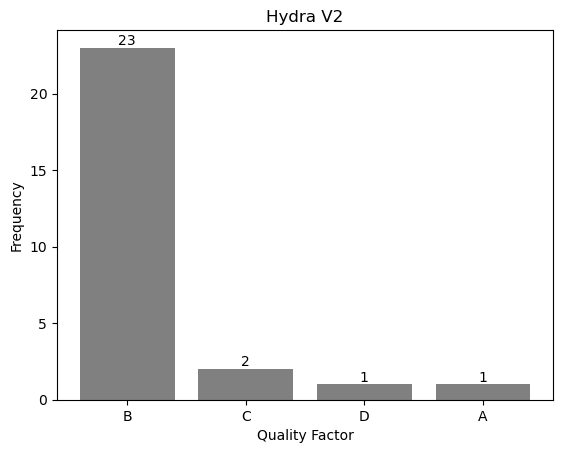

In [111]:
plot_freq(hv2, 'Hydra V2')

# Hydra V4

In [112]:
hv4=classify(merged_hydrav4)

In [113]:
hv4

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,L
0,j105042-2733_cube_4k,1.000202,0.020107,6.174834,0.030338,0.187334,0.217673,"[0.6730172986824131, 0.6730493436469002, 0.673...","[0.9870588784278439, 1.0113377368615386, 1.012...","[-181.776231502, -177.86027147749002, -173.944...","[0.05409796, 0.060751177, 0.060587432, 0.05833...","[0.8315073, 0.84951276, 0.8468297, 0.85751325,...",0.002954,"[0.15488574932771992, 0.14741931031973254, 0.1...",0.007920,A
1,j100634-2914_cube_4k,1.000180,0.018985,2.388203,0.031489,0.075202,0.106691,"[0.12863738014584664, 0.12863626466522798, 0.1...","[1.0048688791192986, 1.0200790604538612, 0.996...","[-186.922169318, -183.00614211677, -179.090114...","[0.012088115, 0.011786329, 0.011413067, 0.0125...","[0.18901585, 0.19148718, 0.18641716, 0.1901023...",0.000648,"[0.3554161425123079, 0.3617756046848435, 0.349...",0.010656,B
2,j103742-2823_cube_4k,1.000195,0.019771,0.767543,0.057844,0.044398,0.102241,"[0.2784238100819744, 0.2784451415247826, 0.278...","[0.9867904972606633, 1.040750678618709, 1.0162...","[-183.368434628, -179.45245381836, -175.536473...","[0.034588233, 0.030011555, 0.03146964, 0.03391...","[0.41548446, 0.42786187, 0.4169606, 0.41265506...",0.001550,"[0.3645536733981699, 0.3713784206546069, 0.351...",0.011982,B
3,j100911-2855_cube_4k,1.000161,0.017943,1.231936,0.045510,0.056065,0.101575,"[0.4696981670650102, 0.46971175058925463, 0.46...","[1.006163773116426, 1.0258632009855095, 1.0042...","[-186.526542223, -182.61052018641, -178.694498...","[0.076690674, 0.07966181, 0.07871319, 0.077766...","[0.6625869, 0.6704787, 0.6579036, 0.65312296, ...",0.002195,"[0.22720694773604744, 0.21794764259658828, 0.2...",0.007858,B
4,j104623-2622_cube_4k,1.000895,0.042308,0.845282,0.115435,0.097575,0.213010,"[0.1245306824767686, 0.12453509086929188, 0.12...","[1.0477511036233238, 0.9024249246981662, 0.981...","[-181.855047863, -177.9390868096, -174.0231257...","[0.01379271, 0.012511051, 0.01235167, 0.013475...","[0.16579852, 0.14782529, 0.15966548, 0.1677328...",0.001378,"[0.13967982311046123, 0.1509329463315474, 0.16...",0.027165,B
5,j104540-2927_cube_4k,1.000353,0.026572,11.297577,0.025228,0.285010,0.310237,"[0.6067351593902205, 0.6067822885048451, 0.606...","[0.9937161060617415, 0.9991253065310248, 1.013...","[-182.941470484, -179.02549524808998, -175.109...","[0.05754726, 0.065527365, 0.062280785, 0.05834...","[0.8267064, 0.8330197, 0.8398669, 0.83006, 0.8...",0.003869,"[0.25485683200120446, 0.24660363285076148, 0.2...",0.012478,A
6,j104437-2712_cube_4k,1.000122,0.015629,3.665905,0.030185,0.110656,0.140841,"[0.5379791893085806, 0.5379867102793189, 0.537...","[1.006741674703218, 1.0034411439637978, 0.9948...","[-182.392284235, -178.47631616834002, -174.560...","[0.058653343, 0.059888043, 0.058968883, 0.0604...","[0.7819566, 0.7798992, 0.77750945, 0.78214836,...",0.002088,"[0.3260957742224422, 0.3232582953916687, 0.329...",0.008456,A
7,j102429-3013_cube_4k,1.000207,0.020372,1.567231,0.050514,0.079167,0.129682,"[0.2925055355797542, 0.292500095048288, 0.2924...","[0.9997394730338927, 0.9758496658022562, 0.992...","[-185.409628235, -181.49362077897, -177.577613...","[0.027622132, 0.025960868, 0.029448535, 0.0276...","[0.42966482, 0.42208582, 0.43641374, 0.430448,...",0.001734,"[0.3569544512833398, 0.3606379511964295, 0.380...",0.014315,B
8,j101153-2610_cube_4k,1.000105,0.014475,0.986243,0.039547,0.039003,0.078551,"[0.4818079635321702, 0.48180468261149145, 0.48...","[0.9920331463514428, 0.9927423855813557, 0.984...","[-185.495897682, -181.57988909978, -177.663880...","[0.054693498, 0.053406753, 0.056805022, 0.0530...","[0.6931468, 0.6892026, 0.6974019, 0.70225567, ...",0.002403,"[0.3181229613167921, 0.3119069790750346, 0.329...",0.012426,B
9,j100855-3011_cube_4k,1.000252,0.022460,1.364451,0.049573,0.067640,0.117212,"[0.15524812291815712, 0.15527129236024706, 0.1...","[1.0108697422559658, 1.0416199127444594, 1.032...","[-186.94649936, -183.030471841

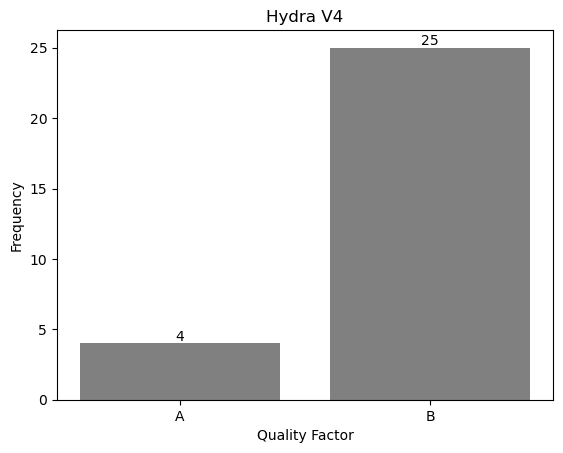

In [114]:
plot_freq(hv4, 'Hydra V4')

Practically until here is the classification, the below part is optional

## This classification is based on the firts function that analyce the data dpending on the criteria that we want.

### S/N test
This test is failed if (maximum signal/maximum noise) < 3

In [185]:
classification_sn(merged_normav2,'S/N')

In [186]:
merged_normav2

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,S/NL,S.RangeL
0,j164153-5951_cube_v2,1.190318,0.645642,0.654049,2.626105,1.717602,4.343707,"[0.03662544264946569, 0.03662486270399789, 0.0...","[1.1275457445045365, 0.7491573203086698, 1.918...","[-119.419412554, -119.213304019776, -119.00719...","[0.0069653937, 0.0059084054, 0.009859838, 0.00...","[0.037103742, 0.021052236, 0.0534945, 0.067613...",0.004059,"[0.6371523205034973, 0.6681643233102371, 1.059...",0.199539,F,E
1,j161749-7717_cube_v2,1.000633,0.035584,3.725970,0.093437,0.348142,0.441578,"[1.6547208783732805, 1.6547209831736227, 1.654...","[1.049161718263138, 1.028367390819176, 0.96861...","[-153.19347372, -152.987359681195, -152.781245...","[0.12359515, 0.1242299, 0.1354541, 0.14697728,...","[3.2458353, 3.1566486, 3.0171447, 3.0345502, 3...",0.008875,"[0.8216164086344333, 0.7881287540251543, 0.756...",0.032251,E,A
2,j165824-6116_cube_v2,1.081245,0.411176,0.889572,1.499506,1.333919,2.833425,"[0.06262569096303372, 0.06262786741390448, 0.0...","[0.8836879745193814, 0.7817738176588436, 1.612...","[-145.195129302, -144.98902075942698, -144.782...","[0.01759998, 0.012424738, 0.015404423, 0.01046...","[0.07224049, 0.062241852, 0.12846124, 0.110425...",0.003691,"[0.18799630404373835, 0.1631230034733192, 0.01...",0.236666,F,C
3,j161051-5750_cube_v2,1.295419,0.822917,0.767435,3.452504,2.649573,6.102077,"[0.02207971299868274, 0.022075326893242053, 0....","[1.1965028712817105, 1.481449636426972, 0.9503...","[-118.178827908, -117.972720226344, -117.76661...","[0.0030261613, 0.001607301, 0.0013697861, 0.00...","[0.050163157, 0.057605214, 0.03372022, 0.10551...",0.003137,"[0.5120626566019173, 0.6288500816687859, 0.088...",0.471175,F,F
4,j165449-6013_cube_v2,1.147433,0.562491,0.946700,1.924945,1.822345,3.747290,"[0.03220873886338623, 0.03221170632598397, 0.0...","[2.2502633619843655, 1.7890497453565006, 1.140...","[-144.996043125, -144.789934719234, -144.58382...","[0.009199487, 0.008886908, 9.2447626e-05, 0.00...","[0.102004886, 0.099307, 0.07321684, 0.11413966...",0.002810,"[0.3693955702957967, 0.756317030718477, 0.8675...",0.415187,F,D
5,j162854-6151_cube_v2,1.001685,0.058074,2.354903,0.184619,0.434761,0.619380,"[0.5102729708539946, 0.5102727087559706, 0.510...","[1.0488262764620044, 0.9542883474743589, 0.992...","[-146.511379438, -146.30526999093803, -146.099...","[0.021715928, 0.023407884, 0.023874797, 0.0179...","[0.8027837, 0.7508683, 0.78732973, 0.8445363, ...",0.002967,"[0.46441502188589956, 0.45389746369979744, 0.4...",0.036802,F,A
6,j155657-7914_cube_v2,1.001770,0.059525,11.541758,0.049236,0.568271,0.617507,"[4.218890489892372, 4.218894269481399, 4.21889...","[1.005431548925607, 1.0176105694461346, 1.0065...","[-154.444639726, -154.23852482742902, -154.032...","[0.23117955, 0.21683922, 0.2054389, 0.2247057,...","[4.249723, 4.319605, 4.278414, 4.212304, 4.259...",0.015658,"[0.0640535962847717, 0.05627033442970519, 0.05...",0.009804,A,A
7,j163405-5908_cube_v2,1.102394,0.463930,0.763025,2.022777,1.543429,3.566206,"[0.03570889330143727, 0.035710724639345416, 0....","[0.863847326199785, 1.0119390845456224, 1.3542...","[-118.692230459, -118.486122424518, -118.28001...","[0.008894772, 0.0072634416, 0.002679781, 0.005...","[0.02546627, 0.02572013, 0.030325273, 0.021544...",0.003068,"[0.6574914575887483, 0.7528031976675847, 0.837...",0.154343,F,D
8,j161502-5905_cube_v2,1.060647,0.353486,0.813643,1.549043,1.260367,2.809410,"[0.06037177411783217, 0.06036866086577595, 0.0...","[1.0116080551285445, 0.931797412652065, 1.2479...","[-119.037702388, -118.831594116099, -118.62548...","[0.0052409093, 0.0035675613, 0.0057701063, 0.0...","[0.09859812, 0.09611191, 0.12360262, 0.1095046...",0.002983,"[0.3865253065079397, 0.4529430222481503, 0.555...",0.200808,F,C
9,j163925-6044_cube_v2,1.075017,0.394492,1.005095,1.400255,1.407389,2.807644,"[0.048151100485425674, 0.04815319960175451, 0....","[0.9938476071691167, 1.4592005221069426, 0.840...","

In [187]:
resultado = merged_normav2[merged_normav2['S/N'] >3].reset_index(drop=True)

In [188]:
resultado

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,S/NL,S.RangeL
0,j161749-7717_cube_v2,1.000633,0.035584,3.725970,0.093437,0.348142,0.441578,"[1.6547208783732805, 1.6547209831736227, 1.654...","[1.049161718263138, 1.028367390819176, 0.96861...","[-153.19347372, -152.987359681195, -152.781245...","[0.12359515, 0.1242299, 0.1354541, 0.14697728,...","[3.2458353, 3.1566486, 3.0171447, 3.0345502, 3...",0.008875,"[0.8216164086344333, 0.7881287540251543, 0.756...",0.032251,E,A
1,j155657-7914_cube_v2,1.001770,0.059525,11.541758,0.049236,0.568271,0.617507,"[4.218890489892372, 4.218894269481399, 4.21889...","[1.005431548925607, 1.0176105694461346, 1.0065...","[-154.444639726, -154.23852482742902, -154.032...","[0.23117955, 0.21683922, 0.2054389, 0.2247057,...","[4.249723, 4.319605, 4.278414, 4.212304, 4.259...",0.015658,"[0.0640535962847717, 0.05627033442970519, 0.05...",0.009804,A,A
2,j160011-5810_cube_v2,1.009876,0.140875,3.598360,0.233261,0.839358,1.072619,"[0.4330058719964666, 0.4329979255322497, 0.432...","[1.0224695059184157, 1.0554558649172139, 1.142...","[-117.96595566, -117.759848124636, -117.553740...","[0.024640974, 0.027479267, 0.024029309, 0.0252...","[0.6868381, 0.6928647, 0.7522461, 0.67085814, ...",0.003867,"[0.48004244950458874, 0.45444714512084583, 0.5...",0.078046,E,A
3,j171029-6041_cube_v2,1.002700,0.073539,4.633466,0.166743,0.772599,0.939342,"[0.7874599219915227, 0.7874623254418964, 0.787...","[0.9450219359963963, 1.0291470763953354, 1.029...","[-144.08567623300002, -143.879568452812, -143....","[0.06747887, 0.06561782, 0.058584746, 0.059791...","[1.3443643, 1.4336742, 1.4379104, 1.4045627, 1...",0.004825,"[0.6581197236563678, 0.6897678094850936, 0.703...",0.060332,D,A
4,j161717-5848_cube_v2,1.002051,0.064078,11.667911,0.047866,0.558500,0.606366,"[3.2733104906569475, 3.273332118088581, 3.2733...","[1.0031016640101913, 1.0095081039102114, 1.014...","[-147.007041943, -146.800932155333, -146.59482...","[0.26714334, 0.2672527, 0.27053598, 0.2736402,...","[5.258456, 5.2882843, 5.30514, 5.3704057, 5.33...",0.009178,"[0.5133381940346693, 0.5160008244625902, 0.515...",0.036604,A,A


Based on this test, it is possible to have only 5 good quality spectras. Now let´s plot them.

In [92]:
# This function is important because it is possible to visualize the require data
def images(file): 
    #data=pd.read_table(file) # reading the files
    #conti=file['T_cont'][2]
    amplitude=file['tau'][0] # extracting the information from the files
    velocity=file['velocity'][0]
    #conti=file['T_cont'][2]#/file['T_cont'][2]
    cont=file['T_on'][0]
    env=file['U.env'][0]
    conti=file['T_cont'][0]/file['T_cont'][0]
    off=file['T_off'][0]+3
    
    fig, ax=plt.subplots(figsize=(10,8)) #Plotting the information
    # Customizing the plot
    #ax.plot(velocity, amplitude,linestyle='-', label=r'$e^{-\tau}$')
    ax.plot(velocity, cont,linestyle='-', label='T_on')
    #ax.plot(velocity, env,linestyle='-', label='Env',color='gray')
    ax.plot(velocity, conti,linestyle='-', label='fit_cont', color='red')
    #ax.plot(velocity, off,linestyle='-', label='off', color='orange')
    plt.ylabel('Amplitude')
    plt.xlabel('Velocity [km/s]')
    plt.title(file['Name'][2])
    ax.legend()
    plt.show()

In [ ]:
images(resultado)

### Range test
This test is failed if Range(exp[−τ ]) > 1.5

In [179]:
classification_sn(merged_normav2,'S.Range')

In [180]:
resultado1 = merged_normav2[merged_normav2['S.Range'] <1.5].reset_index(drop=True)

In [181]:
resultado1

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,S/NL,S.RangeL
0,j161749-7717_cube_v2,1.000633,0.035584,3.725970,0.093437,0.348142,0.441578,"[1.6547208783732805, 1.6547209831736227, 1.654...","[1.049161718263138, 1.028367390819176, 0.96861...","[-153.19347372, -152.987359681195, -152.781245...","[0.12359515, 0.1242299, 0.1354541, 0.14697728,...","[3.2458353, 3.1566486, 3.0171447, 3.0345502, 3...",0.008875,"[0.8216164086344333, 0.7881287540251543, 0.756...",0.032251,B,A
1,j162854-6151_cube_v2,1.001685,0.058074,2.354903,0.184619,0.434761,0.619380,"[0.5102729708539946, 0.5102727087559706, 0.510...","[1.0488262764620044, 0.9542883474743589, 0.992...","[-146.511379438, -146.30526999093803, -146.099...","[0.021715928, 0.023407884, 0.023874797, 0.0179...","[0.8027837, 0.7508683, 0.78732973, 0.8445363, ...",0.002967,"[0.46441502188589956, 0.45389746369979744, 0.4...",0.036802,A,A
2,j155657-7914_cube_v2,1.001770,0.059525,11.541758,0.049236,0.568271,0.617507,"[4.218890489892372, 4.218894269481399, 4.21889...","[1.005431548925607, 1.0176105694461346, 1.0065...","[-154.444639726, -154.23852482742902, -154.032...","[0.23117955, 0.21683922, 0.2054389, 0.2247057,...","[4.249723, 4.319605, 4.278414, 4.212304, 4.259...",0.015658,"[0.0640535962847717, 0.05627033442970519, 0.05...",0.009804,F,A
3,j160011-5810_cube_v2,1.009876,0.140875,3.598360,0.233261,0.839358,1.072619,"[0.4330058719964666, 0.4329979255322497, 0.432...","[1.0224695059184157, 1.0554558649172139, 1.142...","[-117.96595566, -117.759848124636, -117.553740...","[0.024640974, 0.027479267, 0.024029309, 0.0252...","[0.6868381, 0.6928647, 0.7522461, 0.67085814, ...",0.003867,"[0.48004244950458874, 0.45444714512084583, 0.5...",0.078046,B,A
4,j171029-6041_cube_v2,1.002700,0.073539,4.633466,0.166743,0.772599,0.939342,"[0.7874599219915227, 0.7874623254418964, 0.787...","[0.9450219359963963, 1.0291470763953354, 1.029...","[-144.08567623300002, -143.879568452812, -143....","[0.06747887, 0.06561782, 0.058584746, 0.059791...","[1.3443643, 1.4336742, 1.4379104, 1.4045627, 1...",0.004825,"[0.6581197236563678, 0.6897678094850936, 0.703...",0.060332,C,A
5,j161853-5910_cube_v2,1.016147,0.180426,1.675066,0.519478,0.870160,1.389638,"[0.26260253769942166, 0.26260465276606865, 0.2...","[1.2887457332471366, 1.0860877634718453, 1.236...","[-146.99695509100002, -146.79084531026402, -14...","[0.030072805, 0.023345072, 0.029349288, 0.0230...","[0.22510248, 0.16412193, 0.19382572, 0.1818559...",0.004785,"[0.6007347870771078, 0.6046774534501442, 0.664...",0.098533,A,B
6,j162909-6133_cube_v2,1.004524,0.095231,1.718285,0.399653,0.686717,1.086370,"[0.23742738350529097, 0.23742811908784095, 0.2...","[0.9949956762031853, 0.9831010787464626, 1.215...","[-146.34414381899998, -146.13803448685698, -14...","[0.011327287, 0.0095129125, 0.008059633, 0.008...","[0.3508978, 0.35685828, 0.45568925, 0.37549663...",0.002406,"[0.4048139833961808, 0.4494504061309338, 0.639...",0.061802,A,A
7,j154606-7310_cube_v2,1.014280,0.169598,1.284788,0.645468,0.829290,1.474758,"[0.28634221738182103, 0.2863435631246783, 0.28...","[1.2849552656406829, 1.1764314738701653, 0.958...","[-153.364213698, -153.15809954186702, -152.951...","[0.06815767, 0.07533928, 0.07394868, 0.0949500...","[0.31246713, 0.37555277, 0.3147754, 0.3036253,...",0.015826,"[0.5975571273594376, 0.293802455841887, 0.2828...",0.165147,A,B
8,j161717-5848_cube_v2,1.002051,0.064078,11.667911,0.047866,0.558500,0.606366,"[3.2733104906569475, 3.273332118088581, 3.2733...","[1.0031016640101913, 1.0095081039102114, 1.014...","[-147.007041943, -146.800932155333, -146.59482...","[0.26714334, 0.2672527, 0.27053598, 0.2736402,...","[5.258456, 5.2882843, 5.30514, 5.3704057, 5.33...",0.009178,"[0.5133381940346693, 0.5160008244625902, 0.515...",0.036604,F,A


It is important to say that when the spectral range is considered, all the spectra are good ( A-C category)

## Envelop test

This test is failed if the standard deviation of this envelope, over the whole velocity
range, is large: i.e., 3σ(Δabs) > 1.

In [98]:
classification_sn(merged_normav2,'S.env')

In [99]:
resultado2 = merged_normav2[3*merged_normav2['S.env'] <1].reset_index(drop=True)

In [100]:
resultado2

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,S/NL,S.RangeL,S.envL
0,j164153-5951_cube_v2,1.190318,0.645642,0.654049,2.626105,1.717602,4.343707,"[0.03662544264946569, 0.03662486270399789, 0.0...","[1.1275457445045365, 0.7491573203086698, 1.918...","[-119.419412554, -119.213304019776, -119.00719...","[0.0069653937, 0.0059084054, 0.009859838, 0.00...","[0.037103742, 0.021052236, 0.0534945, 0.067613...",0.004059,"[0.6371523205034973, 0.6681643233102371, 1.059...",0.199539,A,E,B
1,j161749-7717_cube_v2,1.000633,0.035584,3.725970,0.093437,0.348142,0.441578,"[1.6547208783732805, 1.6547209831736227, 1.654...","[1.049161718263138, 1.028367390819176, 0.96861...","[-153.19347372, -152.987359681195, -152.781245...","[0.12359515, 0.1242299, 0.1354541, 0.14697728,...","[3.2458353, 3.1566486, 3.0171447, 3.0345502, 3...",0.008875,"[0.8216164086344333, 0.7881287540251543, 0.756...",0.032251,B,A,A
2,j165824-6116_cube_v2,1.081245,0.411176,0.889572,1.499506,1.333919,2.833425,"[0.06262569096303372, 0.06262786741390448, 0.0...","[0.8836879745193814, 0.7817738176588436, 1.612...","[-145.195129302, -144.98902075942698, -144.782...","[0.01759998, 0.012424738, 0.015404423, 0.01046...","[0.07224049, 0.062241852, 0.12846124, 0.110425...",0.003691,"[0.18799630404373835, 0.1631230034733192, 0.01...",0.236666,A,C,B
3,j162854-6151_cube_v2,1.001685,0.058074,2.354903,0.184619,0.434761,0.619380,"[0.5102729708539946, 0.5102727087559706, 0.510...","[1.0488262764620044, 0.9542883474743589, 0.992...","[-146.511379438, -146.30526999093803, -146.099...","[0.021715928, 0.023407884, 0.023874797, 0.0179...","[0.8027837, 0.7508683, 0.78732973, 0.8445363, ...",0.002967,"[0.46441502188589956, 0.45389746369979744, 0.4...",0.036802,A,A,A
4,j155657-7914_cube_v2,1.001770,0.059525,11.541758,0.049236,0.568271,0.617507,"[4.218890489892372, 4.218894269481399, 4.21889...","[1.005431548925607, 1.0176105694461346, 1.0065...","[-154.444639726, -154.23852482742902, -154.032...","[0.23117955, 0.21683922, 0.2054389, 0.2247057,...","[4.249723, 4.319605, 4.278414, 4.212304, 4.259...",0.015658,"[0.0640535962847717, 0.05627033442970519, 0.05...",0.009804,F,A,A
5,j163405-5908_cube_v2,1.102394,0.463930,0.763025,2.022777,1.543429,3.566206,"[0.03570889330143727, 0.035710724639345416, 0....","[0.863847326199785, 1.0119390845456224, 1.3542...","[-118.692230459, -118.486122424518, -118.28001...","[0.008894772, 0.0072634416, 0.002679781, 0.005...","[0.02546627, 0.02572013, 0.030325273, 0.021544...",0.003068,"[0.6574914575887483, 0.7528031976675847, 0.837...",0.154343,A,D,B
6,j161502-5905_cube_v2,1.060647,0.353486,0.813643,1.549043,1.260367,2.809410,"[0.06037177411783217, 0.06036866086577595, 0.0...","[1.0116080551285445, 0.931797412652065, 1.2479...","[-119.037702388, -118.831594116099, -118.62548...","[0.0052409093, 0.0035675613, 0.0057701063, 0.0...","[0.09859812, 0.09611191, 0.12360262, 0.1095046...",0.002983,"[0.3865253065079397, 0.4529430222481503, 0.555...",0.200808,A,C,B
7,j163925-6044_cube_v2,1.075017,0.394492,1.005095,1.400255,1.407389,2.807644,"[0.048151100485425674, 0.04815319960175451, 0....","[0.9938476071691167, 1.4592005221069426, 0.840...","[-146.329461038, -146.123351715947, -145.91724...","[-0.00013470885, 0.0010339649, 0.0029182334, -...","[0.08063194, 0.121514395, 0.06404883, 0.102900...",0.002248,"[0.5434680457231278, 0.9027863546360853, 0.289...",0.212741,A,C,B
8,j160011-5810_cube_v2,1.009876,0.140875,3.598360,0.233261,0.839358,1.072619,"[0.4330058719964666, 0.4329979255322497, 0.432...","[1.0224695059184157, 1.0554558649172139, 1.142...","[-117.96595566, -117.759848124636, -117.553740...","[0.024640974, 0.027479267, 0.024029309, 0.0252...","[0.6868381, 0.6928647, 0.7522461, 0.67085814, ...",0.003867,"[0.48004244950458874, 0.45444714512084583, 0.5...",0.078046,B,A,A
9,j171029-6041_cube_v2,1.002700,0.073539,4.633466,0.166743,0.772599,0.939342,"[0.7874599219915227, 0.7874623254418964, 0.787...","[0.9450219359963963, 1.0291

# Norma V4

### S/N test
This test is failed if (maximum signal/maximum noise) < 3

In [101]:
classification_sn(merged_normav4,'S/N')

In [102]:
resultado_nv4 = merged_normav4[merged_normav4['S/N'] >3].reset_index(drop=True)

In [103]:
resultado_nv4

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,S/NL
0,j165824-6116_cube_4k,1.006085,0.110483,4.839416,0.140724,0.681022,0.821746,"[0.12096863320789887, 0.12099467939031347, 0.1...","[1.006670297668937, 1.0565367059457176, 1.0750...","[-189.611520226, -185.69545791712, -181.779395...","[0.031289257, 0.032483198, 0.034069665, 0.0286...","[0.12788723, 0.14276326, 0.13287051, 0.1472630...",0.002422,"[0.26819479719253403, 0.20514014235587763, 0.3...",0.043641,A
1,j171029-6041_cube_4k,1.000674,0.036711,8.236657,0.041651,0.343064,0.384715,"[0.9277290553043571, 0.9278218484952502, 0.927...","[1.0416508402692704, 1.006816946071067, 1.0073...","[-188.501902864, -184.58585504042, -180.669807...","[0.077052414, 0.07225245, 0.071543306, 0.07252...","[1.550213, 1.5191228, 1.5149522, 1.5277368, 1....",0.004370,"[0.5321381233001863, 0.5384792467778612, 0.534...",0.029271,B
2,j163925-6044_cube_4k,1.004459,0.094541,3.831340,0.182904,0.700767,0.883671,"[0.07870304738699639, 0.07871146495861207, 0.0...","[1.1337112470532156, 1.0466341852907708, 1.061...","[-190.746019941, -186.82994282199, -182.913865...","[0.0050291833, 0.0049379417, 0.0044683903, 0.0...","[0.121061586, 0.11425968, 0.11513901, 0.115513...",0.000717,"[0.31326915049271253, 0.31493497638880497, 0.3...",0.043335,A
3,j165636-6055_cube_4k,1.004717,0.097197,6.621226,0.106076,0.702350,0.808426,"[0.18148796871894995, 0.18157554162782427, 0.1...","[1.1060755785462704, 0.995382518921283, 1.0360...","[-189.584575248, -185.66851329087, -181.752451...","[0.045222234, 0.04874153, 0.04546508, 0.050561...","[0.23249462, 0.22352861, 0.2303504, 0.2288234,...",0.003446,"[0.13117173436617535, 0.08970983598739202, 0.0...",0.034269,B
4,j162150-6045_cube_4k,1.002145,0.065526,3.148669,0.131319,0.413481,0.544800,"[0.0988206887602322, 0.09883689185494711, 0.09...","[0.9785155842681539, 1.0282430790028245, 1.032...","[-190.01613511, -186.10006751914, -182.1839999...","[0.007972244, 0.0061665904, 0.007604703, 0.006...","[0.14167148, 0.14774081, 0.15250702, 0.1435518...",0.000715,"[0.3527114329105938, 0.3824423805167272, 0.411...",0.032353,A
5,j160011-5810_cube_4k,1.002046,0.063979,9.721913,0.047786,0.464568,0.512354,"[0.5259671454331329, 0.5261055391833243, 0.526...","[1.0427836886053712, 1.0261785132276977, 1.045...","[-188.145571452, -184.22952828008, -180.313485...","[0.045332786, 0.04601871, 0.04574263, 0.044546...","[0.74305063, 0.7367749, 0.7465482, 0.7375887, ...",0.002755,"[0.2680444399953028, 0.271072502075808, 0.2703...",0.023622,C
6,j161717-5848_cube_4k,1.000880,0.041950,18.695071,0.018774,0.350988,0.369763,"[3.6055999749827534, 3.6060397985287365, 3.606...","[1.0171337712019877, 1.0171353908785128, 1.018...","[-191.423701185, -187.50761521932003, -183.591...","[0.30605417, 0.3039748, 0.3084479, 0.30760354,...","[5.405578, 5.4076037, 5.4206285, 5.401467, 5.4...",0.004426,"[0.3935178740428591, 0.39448259236616234, 0.39...",0.019823,E
7,j170706-5802_cube_4k,1.001436,0.053614,8.894143,0.062331,0.554380,0.616711,"[0.3059047220672227, 0.3059501021885576, 0.305...","[0.9948053692781065, 1.0192273111509436, 0.993...","[-189.138335424, -185.22227929222, -181.306223...","[0.027949573, 0.030074526, 0.028259614, 0.0266...","[0.35506296, 0.3631985, 0.3590614, 0.3700789, ...",0.001143,"[0.06331457582355293, 0.05838125162832131, 0.0...",0.011985,B
8,j162854-6151_cube_4k,1.000207,0.020335,4.716390,0.038340,0.180826,0.219166,"[0.6101193035618483, 0.6101796493430756, 0.610...","[1.0000662926708197, 0.9956403014326362, 1.006...","[-190.92796528, -187.01188578582, -183.0958062...","[0.03263614, 0.03425111, 0.03201398, 0.0301931...","[0.84984255, 0.846719, 0.8564416, 0.85602146, ...",0.002466,"[0.3272299006715278, 0.32375886291850564, 0.33...",0.010177,A
9,j165657-6023_cube_4k,1.004283,0.092651,3.953598,0.190988,0.755089,0.946077,"[0.17561716470211264, 0.1756451331743403, 0.17...","[1.0127475882080474, 1.0267099164142686, 1.069...","[-189.337497661, -185.42143

In [104]:
merged_normav4.shape

(41, 16)

In [105]:
resultado_nv4.shape

(24, 16)

### Range test
This test is failed if Range(exp[−τ ]) > 1.5

In [106]:
classification_sn(merged_normav4,'S.Range')

In [107]:
resultado_nv41 = merged_normav4[merged_normav4['S.Range'] <1.5]

In [108]:
resultado_nv41.shape

(40, 17)

In [109]:
merged_normav4.shape

(41, 17)

## Envelope test

In [110]:
classification_sn(merged_normav4,'S.env')

In [111]:
resultado_nv42 = merged_normav4[3*merged_normav4['S.env'] <1].reset_index(drop=True)

In [112]:
resultado_nv42

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,S/NL,S.RangeL,S.envL
0,j163254-5938_cube_4k,1.012467,0.158393,2.799868,0.330859,0.926362,1.257221,"[0.042530983062486746, 0.04254030528372538, 0....","[1.0204701813789288, 0.9594086062098386, 1.163...","[-189.100704507, -185.18464886647, -181.268593...","[0.007953435, 0.008256505, 0.008220643, 0.0081...","[0.034958925, 0.033542924, 0.040050708, 0.0371...",0.001229,"[0.4722152470969503, 0.45168421210090515, 0.50...",0.040531,A,C,B
1,j165824-6116_cube_4k,1.006085,0.110483,4.839416,0.140724,0.681022,0.821746,"[0.12096863320789887, 0.12099467939031347, 0.1...","[1.006670297668937, 1.0565367059457176, 1.0750...","[-189.611520226, -185.69545791712, -181.779395...","[0.031289257, 0.032483198, 0.034069665, 0.0286...","[0.12788723, 0.14276326, 0.13287051, 0.1472630...",0.002422,"[0.26819479719253403, 0.20514014235587763, 0.3...",0.043641,A,B,B
2,j162700-6043_cube_4k,1.003848,0.087808,2.432215,0.185919,0.452195,0.638114,"[0.0806538992183123, 0.08066739197251582, 0.08...","[1.0013665276292392, 1.1312469359501718, 1.034...","[-190.206675061, -186.29060498277, -182.374534...","[0.004785371, 0.0060734106, 0.0048848838, 0.00...","[0.11219585, 0.12379762, 0.11526055, 0.1104888...",0.000749,"[0.3025153429990255, 0.3002718118877823, 0.305...",0.041967,A,B,B
3,j171029-6041_cube_4k,1.000674,0.036711,8.236657,0.041651,0.343064,0.384715,"[0.9277290553043571, 0.9278218484952502, 0.927...","[1.0416508402692704, 1.006816946071067, 1.0073...","[-188.501902864, -184.58585504042, -180.669807...","[0.077052414, 0.07225245, 0.071543306, 0.07252...","[1.550213, 1.5191228, 1.5149522, 1.5277368, 1....",0.004370,"[0.5321381233001863, 0.5384792467778612, 0.534...",0.029271,B,A,B
4,j163925-6044_cube_4k,1.004459,0.094541,3.831340,0.182904,0.700767,0.883671,"[0.07870304738699639, 0.07871146495861207, 0.0...","[1.1337112470532156, 1.0466341852907708, 1.061...","[-190.746019941, -186.82994282199, -182.913865...","[0.0050291833, 0.0049379417, 0.0044683903, 0.0...","[0.121061586, 0.11425968, 0.11513901, 0.115513...",0.000717,"[0.31326915049271253, 0.31493497638880497, 0.3...",0.043335,A,B,B
5,j165636-6055_cube_4k,1.004717,0.097197,6.621226,0.106076,0.702350,0.808426,"[0.18148796871894995, 0.18157554162782427, 0.1...","[1.1060755785462704, 0.995382518921283, 1.0360...","[-189.584575248, -185.66851329087, -181.752451...","[0.045222234, 0.04874153, 0.04546508, 0.050561...","[0.23249462, 0.22352861, 0.2303504, 0.2288234,...",0.003446,"[0.13117173436617535, 0.08970983598739202, 0.0...",0.034269,B,B,B
6,j162150-6045_cube_4k,1.002145,0.065526,3.148669,0.131319,0.413481,0.544800,"[0.0988206887602322, 0.09883689185494711, 0.09...","[0.9785155842681539, 1.0282430790028245, 1.032...","[-190.01613511, -186.10006751914, -182.1839999...","[0.007972244, 0.0061665904, 0.007604703, 0.006...","[0.14167148, 0.14774081, 0.15250702, 0.1435518...",0.000715,"[0.3527114329105938, 0.3824423805167272, 0.411...",0.032353,A,A,B
7,j160011-5810_cube_4k,1.002046,0.063979,9.721913,0.047786,0.464568,0.512354,"[0.5259671454331329, 0.5261055391833243, 0.526...","[1.0427836886053712, 1.0261785132276977, 1.045...","[-188.145571452, -184.22952828008, -180.313485...","[0.045332786, 0.04601871, 0.04574263, 0.044546...","[0.74305063, 0.7367749, 0.7465482, 0.7375887, ...",0.002755,"[0.2680444399953028, 0.271072502075808, 0.2703...",0.023622,C,A,A
8,j161717-5848_cube_4k,1.000880,0.041950,18.695071,0.018774,0.350988,0.369763,"[3.6055999749827534, 3.6060397985287365, 3.606...","[1.0171337712019877, 1.0171353908785128, 1.018...","[-191.423701185, -187.50761521932003, -183.591...","[0.30605417, 0.3039748, 0.3084479, 0.30760354,...","[5.405578, 5.4076037, 5.4206285, 5.401467, 5.4...",0.004426,"[0.3935178740428591, 0.39448259236616234, 0.39...",0.019823,E,A,A
9,j170706-5802_cube_4k,1.001436,0.053614,8.894143,0.062331,0.554380,0.616711,"[0.3059047220672227, 0.3059501021885576, 0.305...","[0.9948053692781065, 1.0192

# Hydra V2

In [113]:
classification_sn(merged_hydrav2,'S/N')

In [114]:
resultado_hv2 = merged_hydrav2[merged_hydrav2['S/N'] >3].reset_index(drop=True)

In [115]:
resultado_hv2

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,S/NL
0,j104540-2927_cube_v2,1.002119,0.065132,3.617693,0.140877,0.509648,0.650525,"[0.5339064051194953, 0.5339001536823215, 0.533...","[0.9666124156807866, 1.0464825607307187, 1.050...","[-112.763072177, -112.556968217215, -112.35086...","[0.05686928, 0.05468979, 0.049178064, 0.054622...","[0.80990255, 0.83323777, 0.85815674, 0.8026762...",0.004037,"[0.42112470202193475, 0.38906011957728004, 0.4...",0.04116,F


In [117]:
classification_sn(merged_hydrav2,'S.Range')

In [118]:
resultado_hv21 = merged_hydrav2[merged_hydrav2['S.Range'] <1.5]

In [119]:
resultado_hv21

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,S/NL,S.RangeL
0,j101448-2944_cube_v2,1.015895,0.179003,1.378702,0.576773,0.795198,1.371971,"[0.05446548298906166, 0.054465059204750706, 0....","[0.6974654022186696, 1.0340818650039654, 0.981...","[-141.731690232, -141.525584069403, -141.31947...","[0.0029639732, 0.0027989785, 0.0037379921, 0.0...","[0.055690803, 0.08650606, 0.083565235, 0.09470...",0.001254,"[0.20153216151002262, 0.433732352243561, 0.414...",0.111037,B,C
1,j102229-2647_cube_v2,1.021929,0.210568,0.717456,0.833672,0.598123,1.431796,"[0.0741701685644957, 0.07416811398137559, 0.07...","[1.1328976544920886, 0.7511513642370595, 1.272...","[-160.46988205, -160.263745304649, -160.057608...","[0.007369771, -0.0007924658, 0.011879301, 0.00...","[0.2109097, 0.15082866, 0.18899031, 0.15696697...",0.003621,"[1.4648847630066764, 1.1466880508346997, 0.969...",0.218145,A,C
2,j101153-2610_cube_v2,1.002029,0.063729,0.834408,0.229095,0.191159,0.420254,"[0.3980898559836335, 0.39809002780130254, 0.39...","[1.0290130578379806, 1.0215957486957912, 1.024...","[-141.08011613099998, -140.87401041614598, -14...","[0.041361444, 0.03457511, 0.039043386, 0.04506...","[0.679061, 0.6471227, 0.68487185, 0.7045503, 0...",0.004083,"[0.542112284826997, 0.48634730807186766, 0.566...",0.046435,A,A
4,j103631-2553_cube_v2,1.007091,0.119295,0.868353,0.437726,0.380100,0.817826,"[0.21421313962056365, 0.21420955015343823, 0.2...","[1.108693707681418, 1.0786562962972142, 0.9851...","[-112.718578942, -112.512475012792, -112.30637...","[0.013672062, 0.022938786, 0.025695609, 0.0168...","[0.3485253, 0.40035406, 0.38157168, 0.3756758,...",0.004297,"[0.394305493598863, 0.6230616943387655, 0.6160...",0.097930,A,B
5,j101214-2452_cube_v2,1.008260,0.128796,0.775731,0.531484,0.412288,0.943772,"[0.1356337398456363, 0.13563285513907417, 0.13...","[0.9865987633482277, 1.2059513149102652, 1.192...","[-140.66372168799998, -140.45761625927997, -14...","[0.017702825, 0.015730716, 0.015056325, 0.0139...","[0.22221476, 0.24830489, 0.2305129, 0.217356, ...",0.003343,"[0.44727902782392104, 0.43483436610612025, 0.3...",0.098721,A,B
7,j104540-2927_cube_v2,1.002119,0.065132,3.617693,0.140877,0.509648,0.650525,"[0.5339064051194953, 0.5339001536823215, 0.533...","[0.9666124156807866, 1.0464825607307187, 1.050...","[-112.763072177, -112.556968217215, -112.35086...","[0.05686928, 0.05468979, 0.049178064, 0.054622...","[0.80990255, 0.83323777, 0.85815674, 0.8026762...",0.004037,"[0.42112470202193475, 0.38906011957728004, 0.4...",0.041160,F,A
8,j100855-3011_cube_v2,1.004626,0.096297,0.848535,0.353332,0.299814,0.653146,"[0.12709026622767425, 0.12709066509959552, 0.1...","[0.9193967678899738, 0.8776888051737406, 1.048...","[-142.530503027, -142.324396315482, -142.11828...","[0.0097361915, 0.009367224, 0.009386836, 0.010...","[0.18012333, 0.16361204, 0.16969955, 0.1816697...",0.001472,"[0.38653350317594815, 0.3012231321740233, 0.17...",0.076103,A,A
9,j101313-2546_cube_v2,1.016390,0.181795,0.942427,0.577751,0.544488,1.122239,"[0.10858776694496335, 0.10858818945421533, 0.1...","[1.3579051687722297, 1.1074553006586823, 0.834...","[-140.81002962099998, -140.603924091742, -140....","[0.010992823, 0.011758416, 0.006970684, 0.0067...","[0.2080975, 0.1881661, 0.16493699, 0.1717782, ...",0.003152,"[0.37018340982381215, 0.4300257369150764, 0.53...",0.127778,A,C
10,j103913-2509_cube_v2,1.008964,0.134195,0.901697,0.506107,0.456355,0.962462,"[0.18863142602212518, 0.18863119735233114, 0.1...","[0.9972132638065117, 1.1089793360600475, 1.178...","[-112.186840596, -111.980737032219, -111.77463...","[0.017891092, 0.020000849, 0.02096728, 0.02125...","[0.28521118, 0.3281594, 0.30867907, 0.3084876,...",0.003875,"[0.3583105464904561, 0.4630450358300049, 0.284...",0.100469,A,B
11,j103618-2612_cube_v2,1.005039,0.100510,0.717565,0.442784,0.317726,0.760510,"[0.2858797262856248, 0.28587323351369887, 0.28...","[0.998028169772831, 1.1309586281518977, 0.9675...",

In [120]:
classification_sn(merged_hydrav2,'S.env')

In [121]:
resultado_hv22 = merged_hydrav2[3*merged_hydrav2['S.env'] <1].reset_index(drop=True)

In [122]:
resultado_hv22

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,S/NL,S.RangeL,S.envL
0,j101448-2944_cube_v2,1.015895,0.179003,1.378702,0.576773,0.795198,1.371971,"[0.05446548298906166, 0.054465059204750706, 0....","[0.6974654022186696, 1.0340818650039654, 0.981...","[-141.731690232, -141.525584069403, -141.31947...","[0.0029639732, 0.0027989785, 0.0037379921, 0.0...","[0.055690803, 0.08650606, 0.083565235, 0.09470...",0.001254,"[0.20153216151002262, 0.433732352243561, 0.414...",0.111037,B,C,C
1,j102229-2647_cube_v2,1.021929,0.210568,0.717456,0.833672,0.598123,1.431796,"[0.0741701685644957, 0.07416811398137559, 0.07...","[1.1328976544920886, 0.7511513642370595, 1.272...","[-160.46988205, -160.263745304649, -160.057608...","[0.007369771, -0.0007924658, 0.011879301, 0.00...","[0.2109097, 0.15082866, 0.18899031, 0.15696697...",0.003621,"[1.4648847630066764, 1.1466880508346997, 0.969...",0.218145,A,C,F
2,j101153-2610_cube_v2,1.002029,0.063729,0.834408,0.229095,0.191159,0.420254,"[0.3980898559836335, 0.39809002780130254, 0.39...","[1.0290130578379806, 1.0215957486957912, 1.024...","[-141.08011613099998, -140.87401041614598, -14...","[0.041361444, 0.03457511, 0.039043386, 0.04506...","[0.679061, 0.6471227, 0.68487185, 0.7045503, 0...",0.004083,"[0.542112284826997, 0.48634730807186766, 0.566...",0.046435,A,A,A
3,j100916-2840_cube_v2,1.031682,0.253700,1.225292,0.803610,0.984657,1.788267,"[0.0375449740467146, 0.03754385769569629, 0.03...","[1.127190178566744, 1.3945156734919542, 0.8086...","[-142.01851566500002, -141.812409305305, -141....","[0.00021525113, 0.0009423047, 0.00096942263, 0...","[0.06321158, 0.07908281, 0.051927526, 0.064842...",0.001312,"[0.44585727877661996, 0.5819514124836127, 0.44...",0.143513,B,D,D
4,j103631-2553_cube_v2,1.007091,0.119295,0.868353,0.437726,0.380100,0.817826,"[0.21421313962056365, 0.21420955015343823, 0.2...","[1.108693707681418, 1.0786562962972142, 0.9851...","[-112.718578942, -112.512475012792, -112.30637...","[0.013672062, 0.022938786, 0.025695609, 0.0168...","[0.3485253, 0.40035406, 0.38157168, 0.3756758,...",0.004297,"[0.394305493598863, 0.6230616943387655, 0.6160...",0.097930,A,B,B
5,j101214-2452_cube_v2,1.008260,0.128796,0.775731,0.531484,0.412288,0.943772,"[0.1356337398456363, 0.13563285513907417, 0.13...","[0.9865987633482277, 1.2059513149102652, 1.192...","[-140.66372168799998, -140.45761625927997, -14...","[0.017702825, 0.015730716, 0.015056325, 0.0139...","[0.22221476, 0.24830489, 0.2305129, 0.217356, ...",0.003343,"[0.44727902782392104, 0.43483436610612025, 0.3...",0.098721,A,B,B
6,j101908-2708_cube_v2,1.061407,0.355791,0.654767,1.584319,1.037360,2.621679,"[0.05538563243020711, 0.05538175412583457, 0.0...","[1.4957644494606743, 0.42720911198013567, 1.14...","[-160.655352732, -160.449215859188, -160.24307...","[0.0009870544, -0.0010195831, 0.005497085, 0.0...","[0.12073874, 0.045122743, 0.1029716, 0.1211303...",0.003059,"[0.5006718639523622, 0.24024053044031324, 0.44...",0.235654,A,F,F
7,j104540-2927_cube_v2,1.002119,0.065132,3.617693,0.140877,0.509648,0.650525,"[0.5339064051194953, 0.5339001536823215, 0.533...","[0.9666124156807866, 1.0464825607307187, 1.050...","[-112.763072177, -112.556968217215, -112.35086...","[0.05686928, 0.05468979, 0.049178064, 0.054622...","[0.80990255, 0.83323777, 0.85815674, 0.8026762...",0.004037,"[0.42112470202193475, 0.38906011957728004, 0.4...",0.041160,F,A,A
8,j100855-3011_cube_v2,1.004626,0.096297,0.848535,0.353332,0.299814,0.653146,"[0.12709026622767425, 0.12709066509959552, 0.1...","[0.9193967678899738, 0.8776888051737406, 1.048...","[-142.530503027, -142.324396315482, -142.11828...","[0.0097361915, 0.009367224, 0.009386836, 0.010...","[0.18012333, 0.16361204, 0.16969955, 0.1816697...",0.001472,"[0.38653350317594815, 0.3012231321740233, 0.17...",0.076103,A,A,B
9,j101313-2546_cube_v2,1.016390,0.181795,0.942427,0.577751,0.544488,1.122239,"[0.10858776694496335, 0.10858818945421533, 0.1...","[1.3579051687722297, 1.10745

# Hydra V4

In [123]:
classification_sn(merged_hydrav4,'S/N')

In [124]:
resultado_hv4 = merged_hydrav4[merged_hydrav4['S/N'] >3].reset_index(drop=True)

In [125]:
resultado_hv4

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,S/NL
0,j105042-2733_cube_4k,1.000202,0.020107,6.174834,0.030338,0.187334,0.217673,"[0.6730172986824131, 0.6730493436469002, 0.673...","[0.9870588784278439, 1.0113377368615386, 1.012...","[-181.776231502, -177.86027147749002, -173.944...","[0.05409796, 0.060751177, 0.060587432, 0.05833...","[0.8315073, 0.84951276, 0.8468297, 0.85751325,...",0.002954,"[0.15488574932771992, 0.14741931031973254, 0.1...",0.007920,B
1,j104540-2927_cube_4k,1.000353,0.026572,11.297577,0.025228,0.285010,0.310237,"[0.6067351593902205, 0.6067822885048451, 0.606...","[0.9937161060617415, 0.9991253065310248, 1.013...","[-182.941470484, -179.02549524808998, -175.109...","[0.05754726, 0.065527365, 0.062280785, 0.05834...","[0.8267064, 0.8330197, 0.8398669, 0.83006, 0.8...",0.003869,"[0.25485683200120446, 0.24660363285076148, 0.2...",0.012478,D
2,j104437-2712_cube_4k,1.000122,0.015629,3.665905,0.030185,0.110656,0.140841,"[0.5379791893085806, 0.5379867102793189, 0.537...","[1.006741674703218, 1.0034411439637978, 0.9948...","[-182.392284235, -178.47631616834002, -174.560...","[0.058653343, 0.059888043, 0.058968883, 0.0604...","[0.7819566, 0.7798992, 0.77750945, 0.78214836,...",0.002088,"[0.3260957742224422, 0.3232582953916687, 0.329...",0.008456,B
3,j170336-6212_cube_4k,1.001500,0.054788,18.683949,0.026068,0.487050,0.513118,"[0.6052565786460303, 0.6052911958474236, 0.605...","[1.0009749937048016, 1.0101235639880692, 0.997...","[-192.245054387, -188.32895769912, -184.412861...","[0.040258665, 0.036382467, 0.038464032, 0.0351...","[0.82149625, 0.8351325, 0.8246037, 0.829207, 0...",0.001585,"[0.2819242023282915, 0.30163451917482176, 0.29...",0.020787,F


In [126]:
classification_sn(merged_hydrav4,'S.Range')

In [127]:
resultado_hv41 = merged_hydrav4[merged_hydrav4['S.Range'] <1.5]

In [128]:
resultado_hv41

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,S/NL,S.RangeL
0,j105042-2733_cube_4k,1.000202,0.020107,6.174834,0.030338,0.187334,0.217673,"[0.6730172986824131, 0.6730493436469002, 0.673...","[0.9870588784278439, 1.0113377368615386, 1.012...","[-181.776231502, -177.86027147749002, -173.944...","[0.05409796, 0.060751177, 0.060587432, 0.05833...","[0.8315073, 0.84951276, 0.8468297, 0.85751325,...",0.002954,"[0.15488574932771992, 0.14741931031973254, 0.1...",0.007920,B,B
1,j100634-2914_cube_4k,1.000180,0.018985,2.388203,0.031489,0.075202,0.106691,"[0.12863738014584664, 0.12863626466522798, 0.1...","[1.0048688791192986, 1.0200790604538612, 0.996...","[-186.922169318, -183.00614211677, -179.090114...","[0.012088115, 0.011786329, 0.011413067, 0.0125...","[0.18901585, 0.19148718, 0.18641716, 0.1901023...",0.000648,"[0.3554161425123079, 0.3617756046848435, 0.349...",0.010656,A,A
2,j103742-2823_cube_4k,1.000195,0.019771,0.767543,0.057844,0.044398,0.102241,"[0.2784238100819744, 0.2784451415247826, 0.278...","[0.9867904972606633, 1.040750678618709, 1.0162...","[-183.368434628, -179.45245381836, -175.536473...","[0.034588233, 0.030011555, 0.03146964, 0.03391...","[0.41548446, 0.42786187, 0.4169606, 0.41265506...",0.001550,"[0.3645536733981699, 0.3713784206546069, 0.351...",0.011982,A,A
3,j100911-2855_cube_4k,1.000161,0.017943,1.231936,0.045510,0.056065,0.101575,"[0.4696981670650102, 0.46971175058925463, 0.46...","[1.006163773116426, 1.0258632009855095, 1.0042...","[-186.526542223, -182.61052018641, -178.694498...","[0.076690674, 0.07966181, 0.07871319, 0.077766...","[0.6625869, 0.6704787, 0.6579036, 0.65312296, ...",0.002195,"[0.22720694773604744, 0.21794764259658828, 0.2...",0.007858,A,A
4,j104623-2622_cube_4k,1.000895,0.042308,0.845282,0.115435,0.097575,0.213010,"[0.1245306824767686, 0.12453509086929188, 0.12...","[1.0477511036233238, 0.9024249246981662, 0.981...","[-181.855047863, -177.9390868096, -174.0231257...","[0.01379271, 0.012511051, 0.01235167, 0.013475...","[0.16579852, 0.14782529, 0.15966548, 0.1677328...",0.001378,"[0.13967982311046123, 0.1509329463315474, 0.16...",0.027165,A,B
5,j104540-2927_cube_4k,1.000353,0.026572,11.297577,0.025228,0.285010,0.310237,"[0.6067351593902205, 0.6067822885048451, 0.606...","[0.9937161060617415, 0.9991253065310248, 1.013...","[-182.941470484, -179.02549524808998, -175.109...","[0.05754726, 0.065527365, 0.062280785, 0.05834...","[0.8267064, 0.8330197, 0.8398669, 0.83006, 0.8...",0.003869,"[0.25485683200120446, 0.24660363285076148, 0.2...",0.012478,D,C
6,j104437-2712_cube_4k,1.000122,0.015629,3.665905,0.030185,0.110656,0.140841,"[0.5379791893085806, 0.5379867102793189, 0.537...","[1.006741674703218, 1.0034411439637978, 0.9948...","[-182.392284235, -178.47631616834002, -174.560...","[0.058653343, 0.059888043, 0.058968883, 0.0604...","[0.7819566, 0.7798992, 0.77750945, 0.78214836,...",0.002088,"[0.3260957742224422, 0.3232582953916687, 0.329...",0.008456,B,B
7,j102429-3013_cube_4k,1.000207,0.020372,1.567231,0.050514,0.079167,0.129682,"[0.2925055355797542, 0.292500095048288, 0.2924...","[0.9997394730338927, 0.9758496658022562, 0.992...","[-185.409628235, -181.49362077897, -177.577613...","[0.027622132, 0.025960868, 0.029448535, 0.0276...","[0.42966482, 0.42208582, 0.43641374, 0.430448,...",0.001734,"[0.3569544512833398, 0.3606379511964295, 0.380...",0.014315,A,A
8,j101153-2610_cube_4k,1.000105,0.014475,0.986243,0.039547,0.039003,0.078551,"[0.4818079635321702, 0.48180468261149145, 0.48...","[0.9920331463514428, 0.9927423855813557, 0.984...","[-185.495897682, -181.57988909978, -177.663880...","[0.054693498, 0.053406753, 0.056805022, 0.0530...","[0.6931468, 0.6892026, 0.6974019, 0.70225567, ...",0.002403,"[0.3181229613167921, 0.3119069790750346, 0.329...",0.012426,A,A
9,j100855-3011_cube_4k,1.000252,0.022460,1.364451,0.049573,0.067640,0.117212,"[0.15524812291815712, 0.15527129236024706, 0.1...","[1.0108697422559658, 1.0416199127444594, 1.032...","

In [129]:
classification_sn(merged_hydrav4,'S.env')

In [130]:
resultado_hv42 = merged_hydrav4[3*merged_hydrav4['S.env'] <1].reset_index(drop=True)

In [131]:
resultado_hv42

,Name,rms,S.Deviation,S/N,Max.noise,Max.signal,S.Range,T_cont,tau,velocity,T_off,T_on,S_off,U.env,S.env,S/NL,S.RangeL,S.envL
0,j105042-2733_cube_4k,1.000202,0.020107,6.174834,0.030338,0.187334,0.217673,"[0.6730172986824131, 0.6730493436469002, 0.673...","[0.9870588784278439, 1.0113377368615386, 1.012...","[-181.776231502, -177.86027147749002, -173.944...","[0.05409796, 0.060751177, 0.060587432, 0.05833...","[0.8315073, 0.84951276, 0.8468297, 0.85751325,...",0.002954,"[0.15488574932771992, 0.14741931031973254, 0.1...",0.007920,B,B,A
1,j100634-2914_cube_4k,1.000180,0.018985,2.388203,0.031489,0.075202,0.106691,"[0.12863738014584664, 0.12863626466522798, 0.1...","[1.0048688791192986, 1.0200790604538612, 0.996...","[-186.922169318, -183.00614211677, -179.090114...","[0.012088115, 0.011786329, 0.011413067, 0.0125...","[0.18901585, 0.19148718, 0.18641716, 0.1901023...",0.000648,"[0.3554161425123079, 0.3617756046848435, 0.349...",0.010656,A,A,A
2,j103742-2823_cube_4k,1.000195,0.019771,0.767543,0.057844,0.044398,0.102241,"[0.2784238100819744, 0.2784451415247826, 0.278...","[0.9867904972606633, 1.040750678618709, 1.0162...","[-183.368434628, -179.45245381836, -175.536473...","[0.034588233, 0.030011555, 0.03146964, 0.03391...","[0.41548446, 0.42786187, 0.4169606, 0.41265506...",0.001550,"[0.3645536733981699, 0.3713784206546069, 0.351...",0.011982,A,A,A
3,j100911-2855_cube_4k,1.000161,0.017943,1.231936,0.045510,0.056065,0.101575,"[0.4696981670650102, 0.46971175058925463, 0.46...","[1.006163773116426, 1.0258632009855095, 1.0042...","[-186.526542223, -182.61052018641, -178.694498...","[0.076690674, 0.07966181, 0.07871319, 0.077766...","[0.6625869, 0.6704787, 0.6579036, 0.65312296, ...",0.002195,"[0.22720694773604744, 0.21794764259658828, 0.2...",0.007858,A,A,A
4,j104623-2622_cube_4k,1.000895,0.042308,0.845282,0.115435,0.097575,0.213010,"[0.1245306824767686, 0.12453509086929188, 0.12...","[1.0477511036233238, 0.9024249246981662, 0.981...","[-181.855047863, -177.9390868096, -174.0231257...","[0.01379271, 0.012511051, 0.01235167, 0.013475...","[0.16579852, 0.14782529, 0.15966548, 0.1677328...",0.001378,"[0.13967982311046123, 0.1509329463315474, 0.16...",0.027165,A,B,C
5,j104540-2927_cube_4k,1.000353,0.026572,11.297577,0.025228,0.285010,0.310237,"[0.6067351593902205, 0.6067822885048451, 0.606...","[0.9937161060617415, 0.9991253065310248, 1.013...","[-182.941470484, -179.02549524808998, -175.109...","[0.05754726, 0.065527365, 0.062280785, 0.05834...","[0.8267064, 0.8330197, 0.8398669, 0.83006, 0.8...",0.003869,"[0.25485683200120446, 0.24660363285076148, 0.2...",0.012478,D,C,A
6,j104437-2712_cube_4k,1.000122,0.015629,3.665905,0.030185,0.110656,0.140841,"[0.5379791893085806, 0.5379867102793189, 0.537...","[1.006741674703218, 1.0034411439637978, 0.9948...","[-182.392284235, -178.47631616834002, -174.560...","[0.058653343, 0.059888043, 0.058968883, 0.0604...","[0.7819566, 0.7798992, 0.77750945, 0.78214836,...",0.002088,"[0.3260957742224422, 0.3232582953916687, 0.329...",0.008456,B,B,A
7,j102429-3013_cube_4k,1.000207,0.020372,1.567231,0.050514,0.079167,0.129682,"[0.2925055355797542, 0.292500095048288, 0.2924...","[0.9997394730338927, 0.9758496658022562, 0.992...","[-185.409628235, -181.49362077897, -177.577613...","[0.027622132, 0.025960868, 0.029448535, 0.0276...","[0.42966482, 0.42208582, 0.43641374, 0.430448,...",0.001734,"[0.3569544512833398, 0.3606379511964295, 0.380...",0.014315,A,A,B
8,j101153-2610_cube_4k,1.000105,0.014475,0.986243,0.039547,0.039003,0.078551,"[0.4818079635321702, 0.48180468261149145, 0.48...","[0.9920331463514428, 0.9927423855813557, 0.984...","[-185.495897682, -181.57988909978, -177.663880...","[0.054693498, 0.053406753, 0.056805022, 0.0530...","[0.6931468, 0.6892026, 0.6974019, 0.70225567, ...",0.002403,"[0.3181229613167921, 0.3119069790750346, 0.329...",0.012426,A,A,A
9,j100855-3011_cube_4k,1.000252,0.022460,1.364451,0.049573,0.067640,0.117212,"[0.15524812291815712, 0.15527129236024706, 0.1...","[1.0108697422559658, 1.0416